# Step 9: Diffusion Model

## SETUP

In [1]:
!wget https://raw.githubusercontent.com/oreilly-japan/deep-learning-from-scratch-5/main/step09/flower.png

--2024-07-23 12:47:39--  https://raw.githubusercontent.com/oreilly-japan/deep-learning-from-scratch-5/main/step09/flower.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8568 (8.4K) [image/png]
Saving to: ‘flower.png.1’

flower.png.1        100%[===================>]   8.37K  --.-KB/s    in 0.003s  

2024-07-23 12:47:40 (2.34 MB/s) - ‘flower.png.1’ saved [8568/8568]



## simple_unet.py

In [2]:
import torch
from torch import nn


class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )

    def forward(self, x):
        return self.convs(x)


class UNet(nn.Module):
    def __init__(self, in_ch=1):
        super().__init__()

        self.down1 = ConvBlock(in_ch, 64)
        self.down2 = ConvBlock(64, 128)
        self.bot1 = ConvBlock(128, 256)
        self.up2 = ConvBlock(128 + 256, 128)
        self.up1 = ConvBlock(128 + 64, 64)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, x):
        x1 = self.down1(x)
        x = self.maxpool(x1)
        x2 = self.down2(x)
        x = self.maxpool(x2)

        x = self.bot1(x)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x)
        x = self.out(x)
        return x


model = UNet()
x = torch.randn(10, 1, 28, 28)  # dummy input
y = model(x)
print(y.shape)

torch.Size([10, 1, 28, 28])


## gauusian_noise.py

(64, 64, 3)
torch.Size([3, 64, 64])


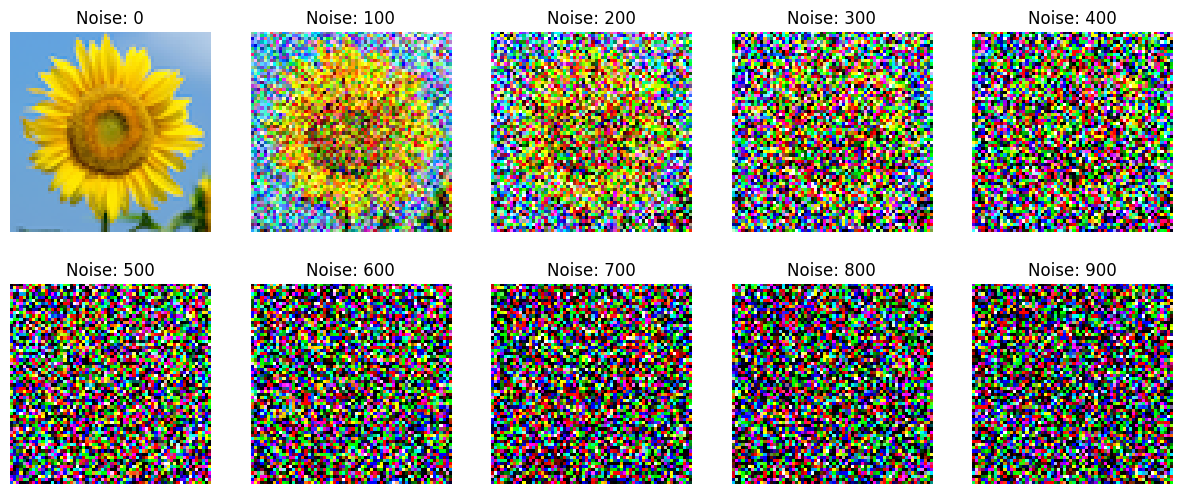

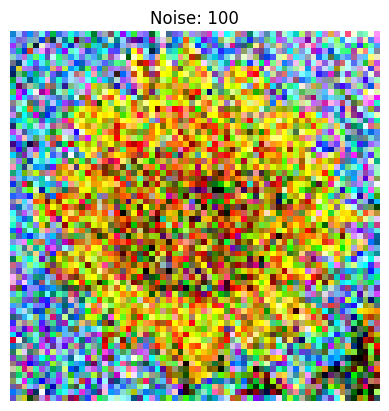

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms


x = torch.randn(3, 64, 64)
T = 1000
betas = torch.linspace(0.0001, 0.02, T)

for t in range(T):
    beta = betas[t]
    eps = torch.randn_like(x)
    x = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps

# load image
file_path = 'flower.png'
image = plt.imread(file_path)
print(image.shape)  # (64, 64, 3)

# preprocess
preprocess = transforms.ToTensor()
x = preprocess(image)
print(x.shape)  # (3, 64, 64)

original_x = x.clone()  # keep original image

def reverse_to_img(x):
    x = x * 255
    x = x.clamp(0, 255)
    x = x.to(torch.uint8)
    to_pil = transforms.ToPILImage()
    return to_pil(x)

T = 1000
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)
imgs = []

for t in range(T):
    if t % 100 == 0:
        img = reverse_to_img(x)
        imgs.append(img)

    beta = betas[t]
    eps = torch.randn_like(x)
    x = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps

# show imgs
plt.figure(figsize=(15, 6))
for i, img in enumerate(imgs[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f'Noise: {i * 100}')
    plt.axis('off')
plt.show()



# ============================================
# q(x_t|x_0)
# ============================================
def add_noise(x_0, t, betas):
    T = len(betas)
    assert t >= 1 and t <= T
    t_idx = t - 1  # betas[0] is for t=1

    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    alpha_bar = alpha_bars[t_idx]

    eps = torch.randn_like(x_0)
    x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * eps
    return x_t

x = original_x

t = 100
x_t = add_noise(x, t, betas)

img = reverse_to_img(x_t)
plt.imshow(img)
plt.title(f'Noise: {t}')
plt.axis('off')
plt.show()

## diffusion_model.py

In [ ]:
import math
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm


img_size = 28
batch_size = 128
num_timesteps = 1000
epochs = 10
lr = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def show_images(images, rows=2, cols=10):
    fig = plt.figure(figsize=(cols, rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, i + 1)
            plt.imshow(images[i], cmap='gray')
            plt.axis('off')
            i += 1
    plt.show()

def _pos_encoding(time_idx, output_dim, device='cpu'):
    t, D = time_idx, output_dim
    v = torch.zeros(D, device=device)

    i = torch.arange(0, D, device=device)
    div_term = torch.exp(i / D * math.log(10000))

    v[0::2] = torch.sin(t / div_term[0::2])
    v[1::2] = torch.cos(t / div_term[1::2])
    return v

def pos_encoding(timesteps, output_dim, device='cpu'):
    batch_size = len(timesteps)
    device = timesteps.device
    v = torch.zeros(batch_size, output_dim, device=device)
    for i in range(batch_size):
        v[i] = _pos_encoding(timesteps[i], output_dim, device)
    return v

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim, in_ch),
            nn.ReLU(),
            nn.Linear(in_ch, in_ch)
        )

    def forward(self, x, v):
        N, C, _, _ = x.shape
        v = self.mlp(v)
        v = v.view(N, C, 1, 1)
        y = self.convs(x + v)
        return y

class UNet(nn.Module):
    def __init__(self, in_ch=1, time_embed_dim=100):
        super().__init__()
        self.time_embed_dim = time_embed_dim

        self.down1 = ConvBlock(in_ch, 64, time_embed_dim)
        self.down2 = ConvBlock(64, 128, time_embed_dim)
        self.bot1 = ConvBlock(128, 256, time_embed_dim)
        self.up2 = ConvBlock(128 + 256, 128, time_embed_dim)
        self.up1 = ConvBlock(128 + 64, 64, time_embed_dim)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, x, timesteps):
        v = pos_encoding(timesteps, self.time_embed_dim, x.device)

        x1 = self.down1(x, v)
        x = self.maxpool(x1)
        x2 = self.down2(x, v)
        x = self.maxpool(x2)

        x = self.bot1(x, v)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x, v)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x, v)
        x = self.out(x)
        return x


class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1  # alpha_bars[0] is for t=1
        alpha_bar = self.alpha_bars[t_idx]  # (N,)
        N = alpha_bar.size(0)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)  # (N, 1, 1, 1)

        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise

    def denoise(self, model, x, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1  # alphas[0] is for t=1
        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx-1]

        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        model.eval()
        with torch.no_grad():
            eps = model(x, t)
        model.train()

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0  # no noise at t=1

        mu = (x - ((1-alpha) / torch.sqrt(1-alpha_bar)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1-alpha) * (1-alpha_bar_prev) / (1-alpha_bar))
        return mu + noise * std

    def reverse_to_img(self, x):
        x = x * 255
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        x = x.cpu()
        to_pil = transforms.ToPILImage()
        return to_pil(x)

    def sample(self, model, x_shape=(20, 1, 28, 28)):
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device)

        for i in tqdm(range(self.num_timesteps, 0, -1)):
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.long)
            x = self.denoise(model, x, t)

        images = [self.reverse_to_img(x[i]) for i in range(batch_size)]
        return images


preprocess = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root='./data', download=True, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

diffuser = Diffuser(num_timesteps, device=device)
model = UNet()
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)

losses = []
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    # generate samples every epoch ===================
    # images = diffuser.sample(model)
    # show_images(images)
    # ================================================

    for images, labels in tqdm(dataloader):
        optimizer.zero_grad()
        x = images.to(device)
        t = torch.randint(1, num_timesteps+1, (len(x),), device=device)

        x_noisy, noise = diffuser.add_noise(x, t)
        noise_pred = model(x_noisy, t)
        loss = F.mse_loss(noise, noise_pred)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(f'Epoch {epoch} | Loss: {loss_avg}')

# plot losses
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# generate samples
images = diffuser.sample(model)
show_images(images)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:04<00:00, 2095439.38it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 164165.64it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:01<00:00, 1166459.05it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 1216897.40it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



 42%|████████████████████████████████████▏                                                  | 195/469 [15:35<22:10,  4.85s/it]